# 纽约出租车费用预测
![u](https://raw.githubusercontent.com/wgq1995/machine-learning/master/predict_texi_fare/Screenshot%20from%202018-10-31%2019-42-23.png)
![u](https://raw.githubusercontent.com/wgq1995/machine-learning/master/predict_texi_fare/Screenshot%20from%202018-10-31%2019-41-06.png)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from sklearn import metrics
% matplotlib inline
plt.style.use('seaborn-whitegrid')

# 1. 转换数据类型
    原始的数值型数据是float64和int64，但是不需要这么高的精度，例如乘客数目uint8就可以
    可以降低一半的内存
![image](https://raw.githubusercontent.com/wgq1995/machine-learning/master/predict_texi_fare/acf3f4029fd14355a6e8914e9892adcb.png)

In [2]:
traintypes = {'fare_amount': 'float16',
              'pickup_datetime': 'object', 
              'pickup_longitude': 'float32',
              'pickup_latitude': 'float32',
              'dropoff_longitude': 'float32',
              'dropoff_latitude': 'float32',
              'passenger_count': 'uint8'}

In [3]:
cols = list(traintypes.keys())
df_train =  pd.read_csv('../data/train.csv', usecols=cols, nrows=2000000)
print('不转换数据类型：')
df_train.info()

cols = list(traintypes.keys())
df_train =  pd.read_csv('../data/train.csv', usecols=cols, dtype=traintypes, nrows=2000000)
print('转换数据类型：')
df_train.info()

df_test =  pd.read_csv('../data/test_data2.csv', dtype=traintypes)

不转换数据类型：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 7 columns):
fare_amount          float64
pickup_datetime      object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      int64
dtypes: float64(5), int64(1), object(1)
memory usage: 106.8+ MB
转换数据类型：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 7 columns):
fare_amount          float16
pickup_datetime      object
pickup_longitude     float32
pickup_latitude      float32
dropoff_longitude    float32
dropoff_latitude     float32
passenger_count      uint8
dtypes: float16(1), float32(4), object(1), uint8(1)
memory usage: 51.5+ MB


# 2.通过describe分析
    1.经纬度的最大最小值不合理：
        longitude(经度)范围:[-180, 180]
        latitude(纬度)范围:[-90, 90]
    2.费用最大最小值不合理：
        费用不可能为负数
        1000多美元对于出注车太大了
    3.乘客数目最大值最小值不合理：
        最大值为208
    4.下车点有一些空值，应该去除

In [4]:
print('训练数据描述：')
df_train.describe().T

训练数据描述：


,count,mean,std,min,25%,50%,75%,max
fare_amount,2000000.0,NaN,NaN,-62.000000,6.000000,8.500000,12.500000,1273.000000
pickup_longitude,2000000.0,-72.523209,12.868041,-3377.680908,-73.992081,-73.981812,-73.967125,2856.441650
pickup_latitude,2000000.0,39.929619,7.983352,-3458.664795,40.734909,40.752628,40.767101,2621.628418
dropoff_longitude,1999986.0,-72.523926,12.774972,-3383.296631,-73.991409,-73.980164,-73.963692,3414.306641
dropoff_latitude,1999986.0,39.928078,10.323815,-3461.540771,40.733997,40.753124,40.768093,3345.917236
passenger_count,2000000.0,1.684113,1.314982,0.000000,1.000000,1.000000,2.000000,208.000000


In [5]:
print('测试数据描述：')
df_test.describe().T

测试数据描述：


,count,mean,std,min,25%,50%,75%,max
fare_amount,9797.0,inf,9.445312,0.000000,6.101562,8.500000,12.500000,97.875000
pickup_longitude,9797.0,-73.975639,0.035659,-74.194481,-73.992104,-73.982109,-73.968353,-73.137390
pickup_latitude,9797.0,40.751045,0.028314,40.578201,40.736633,40.753338,40.767330,41.366138
dropoff_longitude,9797.0,-73.974342,0.036221,-74.183899,-73.991661,-73.980545,-73.964592,-73.137390
dropoff_latitude,9797.0,40.750912,0.032149,40.578201,40.734901,40.753841,40.768196,41.366138
passenger_count,9797.0,1.686639,1.308170,0.000000,1.000000,1.000000,2.000000,6.000000


In [6]:
df_train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.500000,2009-06-15 17:26:21 UTC,-73.844315,40.721317,-73.841614,40.712276,1
1,16.906250,2010-01-05 16:52:16 UTC,-74.016045,40.711304,-73.979271,40.782005,1
2,5.699219,2011-08-18 00:35:00 UTC,-73.982735,40.761269,-73.991241,40.750561,2
3,7.699219,2012-04-21 04:30:42 UTC,-73.987129,40.733143,-73.991570,40.758091,1
4,5.300781,2010-03-09 07:51:00 UTC,-73.968094,40.768009,-73.956657,40.783764,1


In [7]:
# 去除空值
print(df_train.isnull().sum())
print('Old size: %d' % len(df_train))
df_train = df_train.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(df_train))

fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    14
dropoff_latitude     14
passenger_count       0
dtype: int64
Old size: 2000000
New size: 1999986


# 3.数据清洗
    清洗依据：
        费用范围
        乘客数目范围
        经纬度范围

## 3.1 fare_amount分析
    1.应该去除费用小于2.5 且大于150的数据.
    2.在40～60中间有一些奇特值，是因为到机场费用是固定收费
    3.出租车2.5美元起步价，所以去除2.5美元一下的数据

In [8]:
df_train[['fare_amount']].quantile([0.001, 0.999])

,fare_amount
0.001,2.5
0.999,80.0


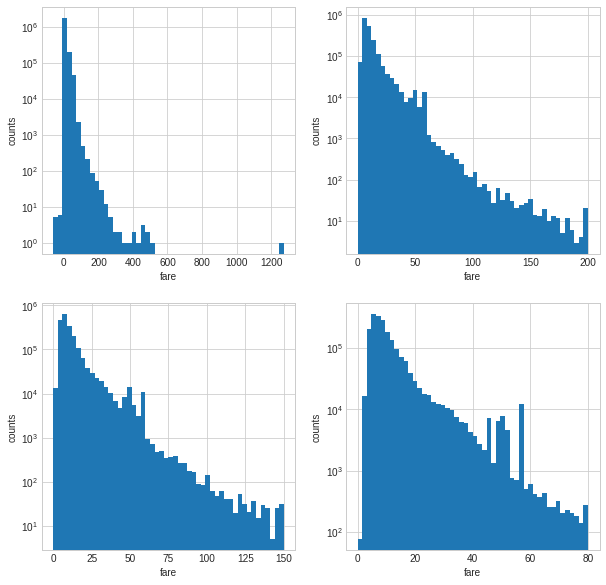

In [9]:
#直方图分析
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.hist(df_train.fare_amount, bins=50, log=True)
plt.xlabel('fare')
plt.ylabel('counts')

plt.subplot(2, 2, 2)
plt.hist(df_train.fare_amount[(df_train.fare_amount <= 200) & (df_train.fare_amount >=0)], 
         bins=50, log=True)
plt.xlabel('fare')
plt.ylabel('counts')

plt.subplot(2, 2, 3)
plt.hist(df_train.fare_amount[(df_train.fare_amount <= 150) & (df_train.fare_amount >=0)], 
         bins=50, log=True)
plt.xlabel('fare')
plt.ylabel('counts')

plt.subplot(2, 2, 4)
plt.hist(df_train.fare_amount[(df_train.fare_amount <= 80) & (df_train.fare_amount >=0)], 
         bins=50, log=True)
plt.xlabel('fare')
plt.ylabel('counts')
plt.show()

In [10]:
# 根据费用信息进行清洗
print('Old size: %d' % len(df_train))
df_train = df_train[(df_train.fare_amount>=2.5) & (df_train.fare_amount <=80)]
print('New size: %d' % len(df_train))

Old size: 1999986
New size: 1997835


## 3.2 乘客数目分析
    乘客数目应该限制在[1, 6]之间
    对于乘客数目为0的数据，虽然有不少，但是0乘客没有意义，且测试集中没有0乘客的数据

In [11]:
df_train[['passenger_count']].quantile([0.00001, 0.99999])

,passenger_count
0.00001,0.0
0.99999,6.0


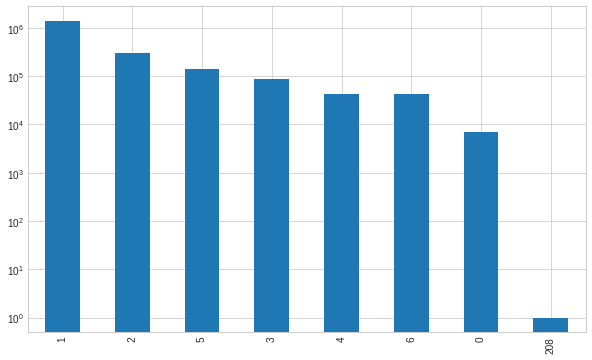

In [12]:
df_train.passenger_count.value_counts().plot(kind="bar", logy=True, figsize=(10, 6))
plt.show()

In [13]:
print('Old size: %d' % len(df_train))
df_train = df_train[(df_train.passenger_count < 7) & (df_train.passenger_count >= 0)]
print('New size: %d' % len(df_train))

Old size: 1997835
New size: 1997834


## 3.3 经纬度分析
    查谷歌得到，纽约的经度在-74左右，纬度在40左右
    截取经度[-76, -72],纬度[39, 42]

In [14]:
#先去除明显不在经纬度范围内的数据
print('Old size: %d' % len(df_train))
df_train = df_train[(df_train.pickup_longitude <= -72) & 
                    (df_train.pickup_longitude >= -76) &
                    (df_train.pickup_latitude <= 42) & 
                    (df_train.pickup_latitude >= 39) & 
                    (df_train.dropoff_longitude <= -72) & 
                    (df_train.dropoff_longitude >= -76) &
                    (df_train.dropoff_latitude <= 42) & 
                    (df_train.dropoff_latitude >= 39)]
print('New size: %d' % len(df_train))

Old size: 1997834
New size: 1956853


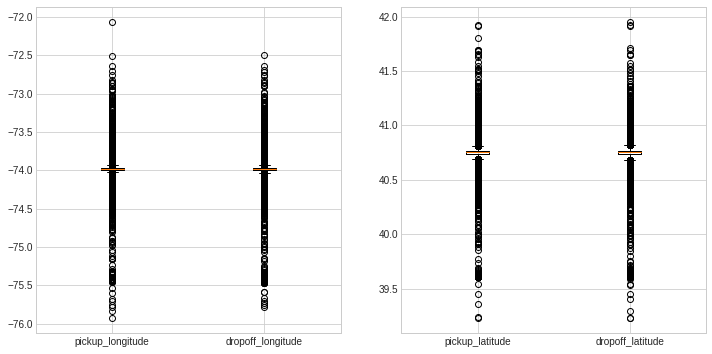

In [15]:
#boxplot分析训练集
plt.figure(figsize=(12,6))
plt.subplot(121)
labels1 = ['pickup_longitude', 'dropoff_longitude']
plt.boxplot([df_train.pickup_longitude, df_train.dropoff_longitude], labels = labels1)

plt.subplot(122)
labels2 = ['pickup_latitude', 'dropoff_latitude']
plt.boxplot([df_train.pickup_latitude, df_train.dropoff_latitude], labels = labels2)

plt.show()

In [16]:
#测试集longitude分布范围
box1 = [min(df_test.pickup_longitude.min(), df_test.dropoff_longitude.min()),
       max(df_test.pickup_longitude.max(), df_test.dropoff_longitude.max()),\
#测试集latitude分布范围
       min(df_test.pickup_latitude.min(), df_test.dropoff_latitude.min()),
       max(df_test.pickup_latitude.max(), df_test.dropoff_latitude.max())
      ]
box1

[-74.194481, -73.13739, 40.578201, 41.366138]

In [17]:
box = (-75, -72, 40, 42)
def select_within_boundingbox(df, B):
    return (df.pickup_longitude >= B[0]) & (df.pickup_longitude <= B[1]) & \
           (df.pickup_latitude >= B[2]) & (df.pickup_latitude <= B[3]) & \
           (df.dropoff_longitude >= B[0]) & (df.dropoff_longitude <= B[1]) & \
           (df.dropoff_latitude >= B[2]) & (df.dropoff_latitude <= B[3])

In [18]:
print('Old size: %d' % len(df_train))
df_train = df_train[select_within_boundingbox(df_train, box)]
print('New size: %d' % len(df_train))

Old size: 1956853
New size: 1956366


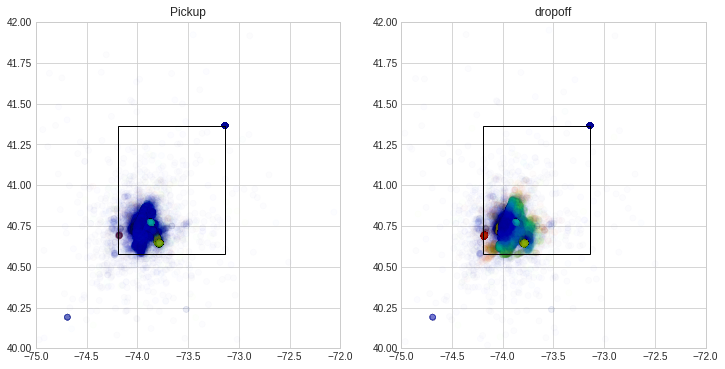

In [19]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.scatter(df_train.pickup_longitude, df_train.pickup_latitude, 
            c=df_train.fare_amount, cmap=plt.get_cmap("jet"), alpha=0.01)
plt.xlim((box[0], box[1]))
plt.ylim((box[2], box[3]))
plt.title('Pickup')
currentAxis1=plt.gca()
rect=Rectangle((box1[0], box1[2]), box1[1] - box1[0], box1[3] - box1[2], fill=False)
currentAxis1.add_patch(rect)

plt.subplot(122)
plt.scatter(df_train.dropoff_longitude, df_train.dropoff_latitude, 
            c=df_train.fare_amount, cmap=plt.get_cmap("jet"), alpha=0.01)
plt.xlim((box[0], box[1]))
plt.ylim((box[2], box[3]))
plt.title('dropoff')
currentAxis1=plt.gca()
rect=Rectangle((box1[0], box1[2]), box1[1] - box1[0], box1[3] - box1[2], fill=False)
currentAxis1.add_patch(rect)
plt.show()

# 4. 特征工程
    时间特征：
        年，月，日，星期，小时
    地理特征：
        根据上下车地点的经纬度求得的地表距离
        方位角(bearing)
[地理信息]https://www.movable-type.co.uk/scripts/latlong.html

    距离：
![image](https://raw.githubusercontent.com/wgq1995/machine-learning/master/predict_texi_fare/Screenshot%20from%202018-10-31%2020-06-26.png)

    方向角：
![image](https://raw.githubusercontent.com/wgq1995/machine-learning/master/predict_texi_fare/Screenshot%20from%202018-10-31%2020-06-43.png)

In [20]:
#时间信息
def add_datetime_info(data):
    """
    添加时间特征：
        年，月，日，小时，星期
    """
    data['pickup_datetime'] =  pd.to_datetime(data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S %Z')#%Z时区
    data['year'] = data['pickup_datetime'].apply(lambda x: x.year)
    data['month'] = data['pickup_datetime'].apply(lambda x: x.month)
    data['day'] = data['pickup_datetime'].apply(lambda x: x.day)
    data['hour'] = data['pickup_datetime'].apply(lambda x: x.hour)
    data['weekday'] = data['pickup_datetime'].apply(lambda x: x.weekday())
    return data

In [21]:
#地理信息
def get_distance(pickup_lon, pickup_lat, dropoff_lon, dropoff_lat):
    """
    计算两点间的球面距离
    """
    pickup_lon,pickup_lat,dropoff_lon,dropoff_lat = map(np.radians,
                                                        [pickup_lon,pickup_lat,
                                                         dropoff_lon,dropoff_lat])
    dlon = dropoff_lon - pickup_lon
    dlat = dropoff_lat - pickup_lat
    
    a = np.sin(dlat/2.0)**2 + np.cos(pickup_lat) * np.cos(dropoff_lat) * np.sin(dlon/2.0)**2
    
    return 12742 * np.arcsin(np.sqrt(a))

def get_bearing(pickup_lon, pickup_lat, dropoff_lon, dropoff_lat,):
    """
    计算方位角
    """
    R_earth = 6371

    pickup_lon,pickup_lat,dropoff_lon,dropoff_lat = map(np.radians,
                                                        [pickup_lon,pickup_lat,
                                                         dropoff_lon,dropoff_lat])
    dlat = dropoff_lat - pickup_lat
    dlon = pickup_lon - dropoff_lon
    
    a = np.arctan2(np.sin(dlon * np.cos(dropoff_lat)),
                   np.cos(pickup_lat) * np.sin(dropoff_lat) - 
                   np.sin(pickup_lat) * np.cos(dropoff_lat) * 
                   np.cos(dlon))
    return a

def add_geography_info(data):
    data['distance'] = get_distance(data['pickup_longitude'], data['pickup_latitude'],
                            data['dropoff_longitude'], data['dropoff_latitude'])
    data['bearing'] = get_bearing(data['pickup_longitude'], data['pickup_latitude'],
                            data['dropoff_longitude'], data['dropoff_latitude'])
    return data

[收费明细]：http://www.nyc.gov/html/tlc/html/passenger/taxicab_rate.shtml

交通信息:

    计量票价信息:
        起始费用为2.50美元
        结束于 New York City or Nassau, Suffolk, Westchester, Rockland, Dutchess, Orange or Putnam Counties有50美分额外费用

    往返通行费:
        乘客必须在Westchester和Nassau县支付往返目的地的所有通行费。
        乘客必须支付往返 Newark Airport 的所有通行费

    机场费用:
        往返JFK和曼哈顿的任何地方这是52美元的固定票价加上通行费，50美分的MTA州附加费，30美分的改善附加费和4.50美元的高
		峰时段附加费（工作日下午4点到晚上8点，不包括法定假日）。
        到纽瓦克机场，附加费为17.50美元

In [22]:
#特殊的交通信息
def add_traffic_info(data):
    """
    特殊交通特征
    """
    #纽约中心 = 曼哈顿
    nyc = (-74.006090, 40.711981)
    
    #城市
    Nassau = (-73.5594, 40.6546)
    Suffolk = (-72.6151, 40.9849)
    Westchester = (-73.7949, 41.1220)
    Rockland = (-73.9830, 41.1489)
    Dutchess = (-73.7478, 41.7784)
    Orange = (-74.3118, 41.3912)
    Putnam = (-73.7949, 41.4351) 

    #机场（纽约两个收费特殊的机场）
    jfk = (-73.7781, 40.6413)#肯尼迪机场
    ewr = (-74.1745, 40.6895)#纽瓦克机场    
    
    #城市
    data['pickup_distance_to_center'] = get_distance(nyc[0], nyc[1],
                                      data['pickup_longitude'], data['pickup_latitude'])
    data['dropoff_distance_to_center'] = get_distance(nyc[0], nyc[1],
                                      data['dropoff_longitude'], data['dropoff_latitude'])
    
    data['pickup_distance_to_Nassau'] = get_distance(Nassau[0], Nassau[1],
                                      data['pickup_longitude'], data['pickup_latitude'])
    data['dropoff_distance_to_Nassau'] = get_distance(Nassau[0], Nassau[1],
                                      data['dropoff_longitude'], data['dropoff_latitude'])
    
    data['dropoff_distance_to_Suffolk'] = get_distance(Suffolk[0], Suffolk[1],
                                      data['dropoff_longitude'], data['dropoff_latitude'])
    
    data['pickup_distance_to_Westchester'] = get_distance(Westchester[0], Westchester[1],
                                      data['pickup_longitude'], data['pickup_latitude'])
    data['dropoff_distance_to_Westchester'] = get_distance(Westchester[0], Westchester[1],
                                      data['dropoff_longitude'], data['dropoff_latitude'])
    
    data['dropoff_distance_to_Rockland'] = get_distance(Rockland[0], Rockland[1],
                                      data['dropoff_longitude'], data['dropoff_latitude'])

    data['dropoff_distance_to_Dutchess'] = get_distance(Dutchess[0], Dutchess[1],
                                      data['dropoff_longitude'], data['dropoff_latitude'])
    
    data['dropoff_distance_to_Orange'] = get_distance(Orange[0], Orange[1],
                                      data['dropoff_longitude'], data['dropoff_latitude'])
    
    data['dropoff_distance_to_Putnam'] = get_distance(Putnam[0], Putnam[1],
                                      data['dropoff_longitude'], data['dropoff_latitude'])
    
    #机场
    data['pickup_distance_to_jfk'] = get_distance(jfk[0], jfk[1],
                                         data['pickup_longitude'], data['pickup_latitude'])
    data['dropoff_distance_to_jfk'] = get_distance(jfk[0], jfk[1],
                                           data['dropoff_longitude'], data['dropoff_latitude'])
    
    data['pickup_distance_to_ewr'] = get_distance(ewr[0], ewr[1], 
                                          data['pickup_longitude'], data['pickup_latitude'])
    data['dropoff_distance_to_ewr'] = get_distance(ewr[0], ewr[1],
                                          data['dropoff_longitude'], data['dropoff_latitude'])
                                                   
    return data

特殊收费规则:

    从晚上8点到早上6点每天收取50美分的附加费。
    工作日下午4点至晚上8点收取1美元的附加费，节假日除外。
团体乘车:

    2, 3, 4 人可以团体乘车

In [23]:
#特殊的收费情况
def add_other_info(data):
    """
    三个额外特征
    """
    #夜间
    data['night_hour'] = np.where((data['hour'] >= 20) |
                                (data['hour'] <= 6), 1, 0)
    
    #晚高峰
    data['peak_hour'] = np.where((data['hour'] >= 16) &
                                (data['hour'] <= 20) & 
                                (data['weekday'] >=0) &
                                (data['weekday'] <=4), 1, 0)
    
    #团体乘车
    data['is_group'] = np.where((data['passenger_count'] >= 2) & 
                                (data['passenger_count'] <= 4), 1, 0)
    
    return data

In [24]:
def add_all_info(data):
    """
    添加所有特征,并且去掉pickup_datetime特征
    """
    data = add_datetime_info(data)
    data = add_geography_info(data)
    data = add_traffic_info(data)
    data = add_other_info(data)
    data.drop(['pickup_datetime'], axis=1, inplace=True)
    
    return data

In [25]:
df_train = add_all_info(df_train)
df_test = add_all_info(df_test)

In [26]:
df_train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,...,dropoff_distance_to_Dutchess,dropoff_distance_to_Orange,dropoff_distance_to_Putnam,pickup_distance_to_jfk,dropoff_distance_to_jfk,pickup_distance_to_ewr,dropoff_distance_to_ewr,night_hour,peak_hour,is_group
0,4.500000,-73.844315,40.721317,-73.841614,40.712276,1,2009,6,15,17,...,118.806770,85.168259,80.469818,10.504698,9.538048,28.056526,28.176485,0,1,0
1,16.906250,-74.016045,40.711304,-73.979271,40.782005,1,2010,1,5,16,...,112.469566,73.248276,74.245476,21.522924,23.071320,13.576503,19.400764,0,1,0
2,5.699219,-73.982735,40.761269,-73.991241,40.750561,2,2011,8,18,0,...,116.087288,76.135559,77.875183,21.806578,21.691015,18.023294,16.870958,1,0,1
3,7.699219,-73.987129,40.733143,-73.991570,40.758091,1,2012,4,21,4,...,115.267639,75.342369,77.062622,20.369770,22.192451,16.521685,17.199459,1,0,0
4,5.300781,-73.968094,40.768009,-73.956657,40.783764,1,2010,3,9,7,...,111.966919,73.810760,73.682373,21.331076,21.850615,19.460770,21.136179,0,0,0


In [27]:
y = df_train['fare_amount'].copy()
df_train.drop(['fare_amount'], axis=1, inplace=True)

test_label = df_test['fare_amount']
df_test.drop(['fare_amount'], axis=1, inplace=True)

In [28]:
x_train,x_test,y_train,y_test = train_test_split(df_train,y,random_state=42,test_size=0.15)

In [29]:
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': 4,
        'num_leaves': 31,
        'learning_rate': 0.029,
        'max_depth': -1,
        'subsample': 0.8,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': True,
        'seed':0,
        'num_rounds':5000
}
cat_features = ['night_hour', 'peak_hour', 'is_group']

In [30]:
train_set = lgbm.Dataset(x_train, y_train, silent=False,categorical_feature=cat_features)
valid_set = lgbm.Dataset(x_test, y_test, silent=False,categorical_feature=cat_features)

model = lgbm.train(params, train_set = train_set, num_boost_round=10000,early_stopping_rounds=500,verbose_eval=500, valid_sets=valid_set)


/home/wgq/anaconda3/envs/oppo/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/wgq/anaconda3/envs/oppo/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/wgq/anaconda3/envs/oppo/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[500]	valid_0's rmse: 3.25739
[1000]	valid_0's rmse: 3.2025
[1500]	valid_0's rmse: 3.1786
[2000]	valid_0's rmse: 3.16185
[2500]	valid_0's rmse: 3.15081
[3000]	valid_0's rmse: 3.14101
[3500]	valid_0's rmse: 3.13224
[4000]	valid_0's rmse: 3.12738
[4500]	valid_0's rmse: 3.12279
[5000]	valid_0's rmse: 3.11839
Did not meet early stopping. Best iteration is:
[4998]	valid_0's rmse: 3.11839


In [31]:
res = pd.DataFrame({
    'feature': model.feature_name(),
    'importance': model.feature_importance()
})
res.sort_values('importance', ascending=False)

,feature,importance
10,distance,11565
11,bearing,10631
8,hour,8318
23,pickup_distance_to_jfk,6920
24,dropoff_distance_to_jfk,6279
14,pickup_distance_to_Nassau,6117
7,day,6056
1,pickup_latitude,5961
17,pickup_distance_to_Westchester,5935
15,dropoff_distance_to_Nassau,5933


In [32]:
#预测
prediction = model.predict(df_test, num_iteration = model.best_iteration)
rmse = np.sqrt(metrics.mean_squared_error(prediction, test_label))
print('均方差误差为:', rmse)

均方差误差为: 3.1771562666
